In [208]:
import numpy as np
import pandas as pd
from matplotlib.pyplot import subplots
import statsmodels.api as sm
from ISLP import load_data
from ISLP.models import (ModelSpec as MS, summarize)

from ISLP import confusion_table
from ISLP.models import contrast
from sklearn.discriminant_analysis import (LinearDiscriminantAnalysis as LDA, \
                                            QuadraticDiscriminantAnalysis as QDA)
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression

In [209]:
Boston = load_data("Boston")
Boston.columns

Index(['crim', 'zn', 'indus', 'chas', 'nox', 'rm', 'age', 'dis', 'rad', 'tax',
       'ptratio', 'lstat', 'medv'],
      dtype='object')

In [210]:
is_high_crime = (Boston.crim > Boston.crim.median())
Boston["is_high_crime"] = is_high_crime

In [211]:
predictors = list(Boston.columns)
predictors.remove("crim")
predictors.remove("is_high_crime")
predictors

['zn',
 'indus',
 'chas',
 'nox',
 'rm',
 'age',
 'dis',
 'rad',
 'tax',
 'ptratio',
 'lstat',
 'medv']

In [212]:
# order the predictors by their correlation with is_high_crime
cor_is_high_crime = {}
for p in predictors: 
    p_series = Boston[p]
    cor_val = p_series.corr(Boston["is_high_crime"])
    cor_is_high_crime[p] = abs(cor_val)

In [213]:
cor_is_high_crime

{'zn': 0.43615102593631355,
 'indus': 0.603260171570645,
 'chas': 0.07009677438940998,
 'nox': 0.7232347950332794,
 'rm': 0.1563717751228881,
 'age': 0.6139399206913059,
 'dis': 0.6163416418258277,
 'rad': 0.6197862490196544,
 'tax': 0.608741282861182,
 'ptratio': 0.25356836320343384,
 'lstat': 0.4532627324454926,
 'medv': 0.26301673420901883}

In [214]:
sorted_predictors = [k for k, v in sorted(cor_is_high_crime.items(), key=lambda item: item[1], reverse=True)]
sorted_predictors

['nox',
 'rad',
 'dis',
 'age',
 'tax',
 'indus',
 'lstat',
 'zn',
 'medv',
 'ptratio',
 'rm',
 'chas']

In [224]:
RANDOM_SEED = 1111
TEST_RATIO = 0.1

In [216]:
def split_data(data, predictor_list, response_str): 
    features = data[predictor_list]
    response = data[response_str]
    
    (X_train, X_test, y_train, y_test) = train_test_split(
        features, response, test_size=round(len(data) * TEST_RATIO), random_state=RANDOM_SEED
    )

    if type(predictor_list) != list: 
        predictor_list = [predictor_list]

    X_train = pd.DataFrame(X_train, columns=predictor_list)
    X_test = pd.DataFrame(X_test, columns=predictor_list)

    # X_train = MS[predictor_list].fit_transform(X_train)
    # X_test = MS[predictor_list].fit_transform(X_test)

    return (X_train, X_test, y_train, y_test)

In [217]:
# logistic regression prediction accuracy
def log_reg_accuracy(data, predictor_list, response_str): 
    (X_train, X_test, y_train, y_test) = split_data(data, predictor_list, response_str)

    log_reg_model = sm.GLM(y_train, X_train, family=sm.families.Binomial())
    results = log_reg_model.fit()
    # print(summarize(results))
    prob_list = results.predict(X_test)
    # print(prob_list)
    pred = np.array([False] * len(y_test))
    pred[prob_list > .5] = "True"

    return np.mean(pred == y_test)

log_reg_accuracy(Boston, sorted_predictors[0:2], "is_high_crime")

0.7647058823529411

In [218]:
# LDA prediction accuracy
def lda_accuracy(data, predictor_list, response_str): 
    (X_train, X_test, y_train, y_test) = split_data(data, predictor_list, response_str)

    # print(X_train.columns)

    lda = LDA(store_covariance=True)
    lda.fit(X_train, y_train)
    pred = lda.predict(X_test)
    
    return np.mean(pred == y_test)

lda_accuracy(Boston, sorted_predictors[0:2], "is_high_crime")

0.9411764705882353

In [219]:
# naive Bayes prediction accuracy
def nb_accuracy(data, predictor_list, response_str): 
    (X_train, X_test, y_train, y_test) = split_data(data, predictor_list, response_str)

    nb = GaussianNB()
    nb.fit(X_train, y_train)
    pred = nb.predict(X_test)

    return np.mean(pred == y_test)

nb_accuracy(Boston, sorted_predictors[0:2], "is_high_crime")

0.9411764705882353

In [220]:
# KNN prediction accuracy
def knn_accuracy(data, predictor_list, response_str): 
    # data pretreatment, i.e. scale
    if type(predictor_list) != list: 
        predictor_list = [predictor_list]

    features = data[predictor_list]
    scaler = StandardScaler(with_mean=True, 
                            with_std=True, 
                            copy=True)
    scaler.fit(features)
    X_std = scaler.transform(features)
    X_std = pd.DataFrame(X_std, 
                         index=features.index,
                         columns=predictor_list)

    # print(X_std)

    (X_train, X_test, y_train, y_test) = train_test_split(X_std, 
                                                          data[response_str], 
                                                          test_size=round(len(data) * TEST_RATIO), 
                                                          random_state=RANDOM_SEED)
    # print(y_train)
    best_accuracy = 0
    best_K = 0
    for K in range(1, 41): 
        knn = KNeighborsClassifier(n_neighbors=K)
        pred = knn.fit(X_train, y_train).predict(X_test)
        accuracy = np.mean(pred == y_test)
        if accuracy > best_accuracy: 
            best_accuracy = accuracy
            best_K = K

    return best_accuracy

knn_accuracy(Boston, sorted_predictors, "is_high_crime")

0.9803921568627451

In [225]:
# accuracy of different methods with different predictors
def classify_accuracy(data, predictor_list, response_str): 
    # logistic regression
    log_reg_res = log_reg_accuracy(data, predictor_list, response_str)

    # LDA
    lda_res = lda_accuracy(data, predictor_list, response_str)

    # KNN
    knn_res = knn_accuracy(data, predictor_list, response_str)

    # NB
    nb_res = nb_accuracy(data, predictor_list, response_str)

    return {
        "log_reg": log_reg_res, 
        "lda": lda_res, 
        "knn": knn_res, 
        "nb": nb_res
    }

In [226]:
accuracy_dict = {
    "log_reg": [], 
    "lda": [], 
    "knn": [], 
    "nb": []
}

for i in range(1, len(sorted_predictors)): 
    predictors_temp = sorted_predictors[: i]
    results_temp = classify_accuracy(Boston, predictors_temp, "is_high_crime")
    for k in accuracy_dict.keys(): 
        accuracy_dict[k].append(results_temp[k])

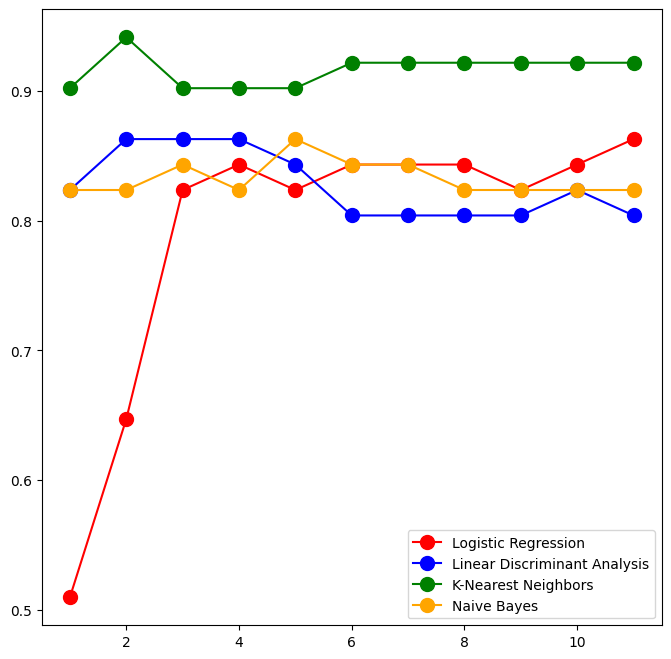

In [227]:
fig, ax = subplots(figsize=(8, 8))
x_axis = list(range(1, len(sorted_predictors)))
ax.plot(x_axis, accuracy_dict["log_reg"], color="red", marker="o", ms=10, label="Logistic Regression")
ax.plot(x_axis, accuracy_dict["lda"], color="blue", marker="o", ms=10, label="Linear Discriminant Analysis")
ax.plot(x_axis, accuracy_dict["knn"], color="green", marker="o", ms=10, label="K-Nearest Neighbors")
ax.plot(x_axis, accuracy_dict["nb"], color="orange", marker="o", ms=10, label="Naive Bayes")
ax.legend()